# Lesson 34: Introduction to image processing with scikit-image

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l34_intro_to_image_processing.ipynb).*

In [21]:
# Our workhorse
import numpy as np

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.morphology
import skimage.exposure

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Seaborn makes plots pretty!
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Set JB's favorite Seaborn settings
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 
    'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)

In this tutorial, we will learn some basic techniques for image processing using [`scikit-image`](http://scikit-image.org) with Python.

## Image processing tools for Python
There are many image processing tools available for Python. Some of them, such as ITK and OpenCV are mature image processing packages that have bindings for Python, allowing easy use of their functionality. Others were developed specifically for Python. Some of the many packages are

* [`scikit-image`](http://scikit-image.org)
* [`scipy.ndimage`](https://docs.scipy.org/doc/scipy-0.15.1/reference/ndimage.html)
* [Open CV](http://opencv.org) (extensive computer vision package)
* [Cell Profiler](http://www.cellprofiler.org) (Broad Institute at MIT)
* [Insight Segmentation and Registration Toolkit](http://www.itk.org) (ITK, used in medical imaging, supported by the NIH)
* [Fiji](http://fiji.sc) and [ImageJ](http://developer.imagej.net) support [Jython](http://www.jython.org) scripting

The first two packages are standard with Anaconda. They provide a set of basic image processing tools, with more sophisticated packages such as ITK and Fiji supplying many more bells and whistles. If in the future you have more demanding image processing requirements, the other packages can prove very useful.  

We will almost exclusively use `scikit-image` along with the standard tools from NumPy.  The package `scipy.ndimage` is quite useful, but we will use `scikit-image`, since it has expanded functionality. We will call is `skimage` for short (which is how the package is imported anyhow). A potential annoyance with `skimage` is that the main package has minimal functionality, and you must import subpackages as needed. For example, to load and view images, you will need to import `skimage.io`. Importantly, `skimage` is well-documented, and you can access the documentation at [http://scikit-image.org/](http://scikit-image.org/).

We will explore `skimage`’s capabilities and some basic image processing techniques through example.  In this lesson, we will take a brightfield and a fluorescent image of bacteria and perform **segementation**, that is the identification of each pixel in the image as being bacteria or background.

## Loading and viewing 12-bit images
We will now load and view the test images we will use for segmentation.  We load the image using the `skimage.io.imread`.  The image is stored as a NumPy array.  Each entry in the array is a pixel value.  This is an important point: **a digital image is data**.  It is a set of numbers with spatial positions.

You should have downloaded the images [`ecoli_phase.tif`](http://bois.caltech.edu/bootcamp/ecoli_phase.tif) and [`ecoli_cfp.tif`](http://bois.caltech.edu/bootcamp/ecoli_cfp.tif).  We'll start with an image taken using phase contrast microscopy of *E. coli*.  These images were acquired by Caltech graduate student Griffin Chure.

/Users/Justin/anaconda/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "


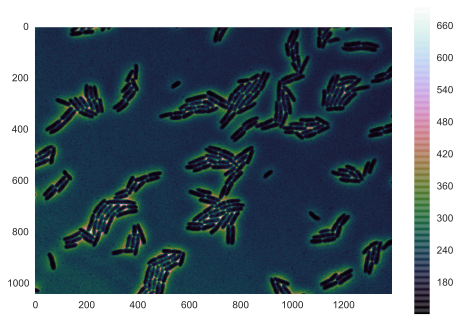

In [22]:
# Load image
im_phase = skimage.io.imread('../data/ecoli_phase.tif')

# Display the image, set Seaborn style 'dark' to avoid grid lines
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase)

We get a warning and then a strange looking picture!  The warning is that we have a low dynamic range.  We get this warning because `skimage` assumes that images with integer pixel values are either 8-bit, 16-bit, or 32-bit.  This image, as is often the case with images acquired with scientific cameras, were acquired with a 12-bit camera.  This means that the pixel values range from 0 to $2^{12}-1=4095$.  This is much less than what we would expect for a maximal pixel value for a 16-bit image, $2^{16}-1 = 65535$.

So, to view the images in their full range, we should divide by the maximal pixel value.

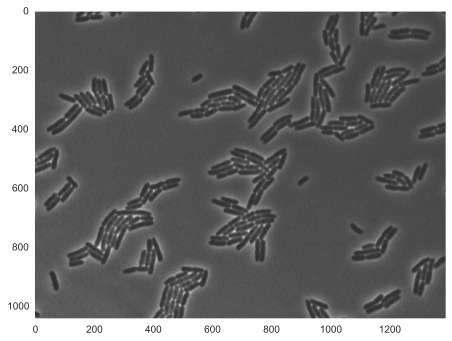

In [23]:
# Load image
im_phase = skimage.io.imread('../data/ecoli_phase.tif')

# Display the image
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase / im_phase.max())

## Lookup tables
As an alternative to stretching the image and using `skimage.io.imshow` to view the image, we can use `matploblib`'s image viewing function, which automatically adjusts the image.  We will need to specify a `gray` colormap to look at it.  In fact, while we're at it, we can specify whatever colormap we want.

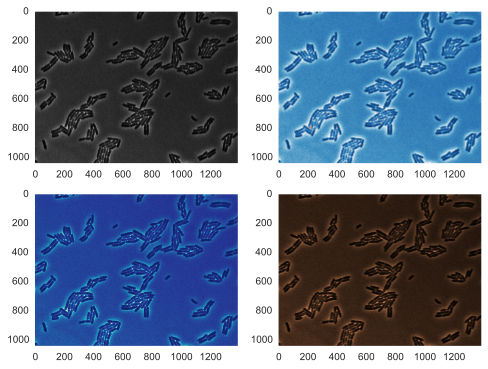

In [24]:
with sns.axes_style('dark'):
    # Get subplots
    fig, ax = plt.subplots(2, 2, figsize=(8,6))

    # Display various LUTs
    ax[0,0].imshow(im_phase, cmap=plt.cm.gray)
    ax[0,1].imshow(im_phase, cmap=plt.cm.RdBu_r)
    ax[1,0].imshow(im_phase, cmap=plt.cm.YlGnBu_r)
    ax[1,1].imshow(im_phase, cmap=plt.cm.copper)

We did a few new things here.  First, we use the `plt.subplots` function to generate subplots.  Second, we used the `imshow` method of the `axes` object to display the images.   Lastly, we specified the **colormap** to be used for showing the image.  We used a grayscale colormap, `plt.cm.gray`.  This specifies how the pixel values are interpreted as they are displayed.  For a grayscale colormap, high pixel values are more white, and low pixel values are more black.

In image processing, a colormap is called a **lookup table** (LUT).  A LUT is a mapping of pixel values to a color. This sometimes helps visualize images, especially when we use false coloring.  Remember, a digital image is data, and false coloring an image if **not** manipulation of data.  It is simply a different way of plotting it.

As we just saw, we specify a lookup table with a **colormap**.  There are plenty available in `matplotlib`.  There is lots of debate about that the best colormaps (LUTs) are. The data visualization community seems to universally reject using rainbow colormaps. See, e.g., D. Borland and R. M. Taylor, Rainbow Color Map (Still) Considered Harmful, IEEE Computer Graphics and Applications, 27,14-17, 2007. In the example, I use a hue-diverging colorscale, which goes from blue to red, as people accustomed to rainbow colormaps expect, but in a perceptually ordered fashion.  In the soon-to-be released Matplotlib 2.0, the colormap [`viridis`](http://matplotlib.org/style_changes.html) will be available and is beautiful!

Importantly, the false coloring helps use see that the intensity of the pixel values near the center of some of the bacteria are not that dissimilar from the background. This will become an issue, as we will see, when segmenting.

## Introductory segmentation
As mentioned before, **segmentation** is the process by which we separate regions of an image according to their identity for easier analysis. E.g., if we have an image of bacteria and we want to determine what is "bacteria" and what is "not bacteria," we would do some segmentation. We will use bacterial test images for this purpose.

### Histograms
As we begin segmentation, remember that viewing an image is just a way of plotting the digital image data.  We can also plot a **histogram**.  This helps use see some patterns in the pixel values and is often an important first step toward segmentation.

The histogram of an image is simply a list of counts of pixel values. When we plot the histogram, we can often readily see breaks in which pixel values are most frequently encountered. There are many ways of looking at histograms. I’ll show you my preferred way.

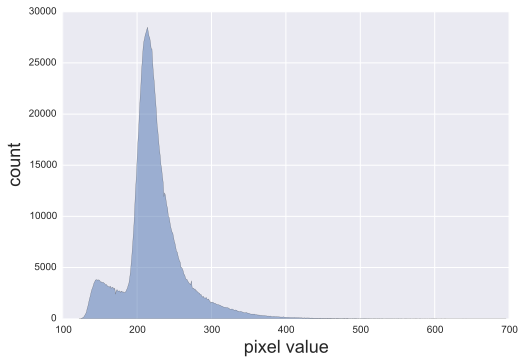

In [25]:
# Get the histogram data
hist_phase, bins_phase = skimage.exposure.histogram(im_phase)

# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins_phase, hist_phase, alpha=0.5)

# Label axes
plt.xlabel('pixel value')
plt.ylabel('count')

We see that there are two peaks to the histogram of the phase image.  The peak to the right is brighter, so likely represents the background.  Therefore, if we can find where the valley between the two peaks is, we may take pixels with intensity below that value to be bacteria and those above to be background.  Eyeballing it, I think this critical pixel value is about 182.

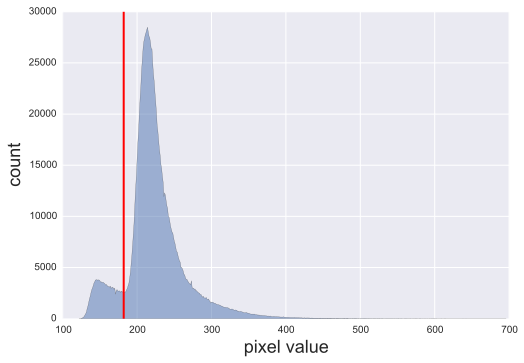

In [26]:
# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins_phase, hist_phase, alpha=0.5)
plt.plot([182, 182], [0, 30000], linestyle='-', marker='None', color='red')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('count')

### Thresholding
The process of taking pixels above or below a certain value is called **thresholding**.  It is one of the simplest ways to segement an image.  We call every pixel with a value below 182 part of a bacterium and everything above *not* part of a bacterium.

In [27]:
# Threshold value, as obtained by eye
thresh_phase = 182

# Generate thresholded image
im_phase_bw = im_phase < thresh_phase

We can overlay these images to get a good view.  To do this, we will make an RGB image, and saturate the green channel where the thresholded image is white.

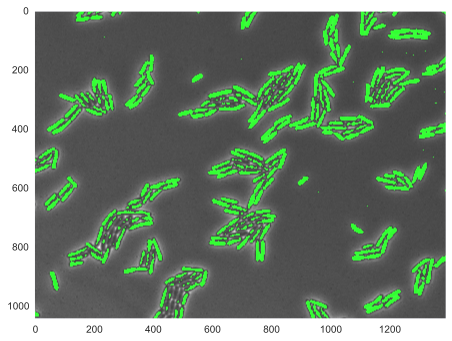

In [28]:
# Build RGB image by stacking grayscale images
im_phase_rgb = np.dstack(3 * [im_phase / im_phase.max()])

# Saturate green channel wherever there are white pixels in thresh image
im_phase_rgb[im_phase_bw, 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_phase_rgb)

We see that we did a decent job finding bacteria, but we do not effectively label the bacteria in the middle of colonies.  This is because of the "halo" of high intensity signal near boundaries of the bacteria that we get from using phase contrast microscopy.

### Using the CFP channel
One way around this issue is to use bacteria that constitutively express a fluoresent protein and to segement in using the fluorescent channel.  Let's try the same procedure with the CFP channel.  First, let's look at the image.

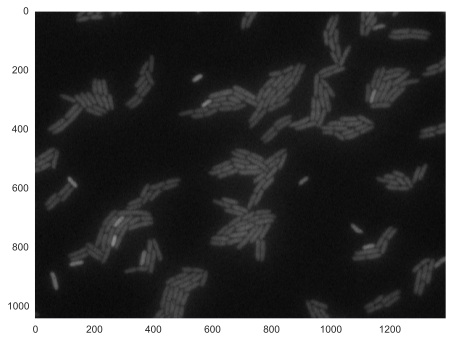

In [29]:
# Load image
im_cfp = skimage.io.imread('../data/ecoli_cfp.tif')

# Display the image
with sns.axes_style('dark'):
    plt.imshow(im_cfp, cmap=plt.cm.gray)

We can also look with a different LUT.

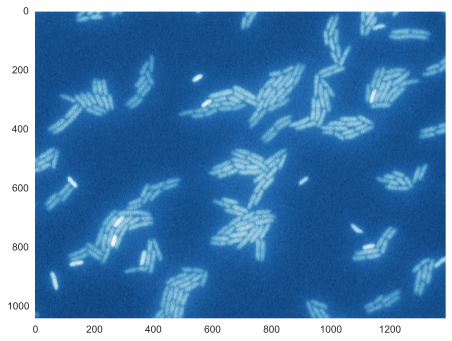

In [30]:
# Display the image with red-blue color map
with sns.axes_style('dark'):
    plt.imshow(im_cfp, cmap=plt.cm.RdBu_r)

We see that the bacteria are typically brighter than the background, so this might help us in segmentation.

### Filtering noise: the median filter

It is strange that there do not appear to be any red (indicating high intensity) pixels in the display of the CFP image with the red-blue LUT.  This is because there are some "bad" pixels in the image, resulting from noise or some other error in the detector.  We can see this if we zoom in on one of the bad pixels.

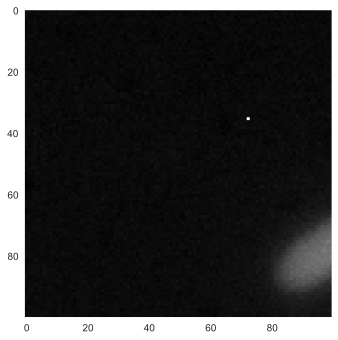

In [31]:
with sns.axes_style('dark'):
    plt.imshow(im_cfp[150:250,450:550] / im_cfp.max(), cmap=plt.cm.gray)

We see a single bright pixel. This will throw off our color map.  We can remove this noise by using a **median filter**.  The concept is simple. We take a shape of pixels, called a **structuring element**, and pass it over the image. The value of the center pixel in the max is replaced by the median value of all pixels in the mask. To do this, we first need to construct a mask. This is done using the `skimage.morphology` module. The filtering is then done using `skimage.filters.rank.median`. Let’s try it with a 3$\times$3 square mask.

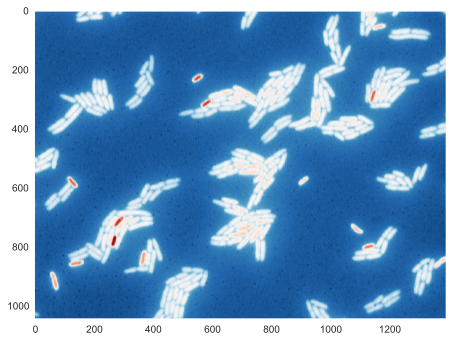

In [32]:
# Make the structuring element
selem = skimage.morphology.square(3)

# Perform the median filter
im_cfp_filt = skimage.filters.median(im_cfp, selem)

# Show filtered image with red-blue LUT
with sns.axes_style('dark'):
    plt.imshow(im_cfp_filt, cmap=plt.cm.RdBu_r)

Now that we have dealt with the noisy pixels, we can now see more clearly that some cells are very bright (shown in red) compared with others.  We also have an image that makes more sense; we have eliminated the noise.

### Thresholding in the CFP channel
We'll proceed by plotting the histogram and finding the threshold value.  Eyeballing it, I get a threshold value of 198.

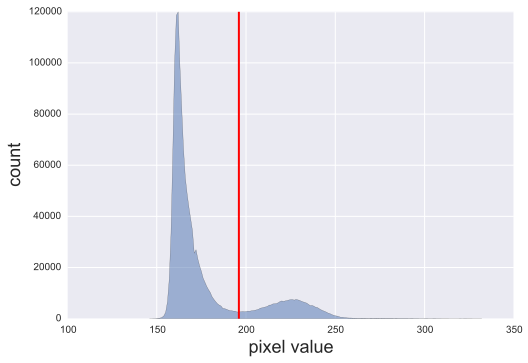

In [33]:
# Get the histogram data
hist_cfp, bins_cfp = skimage.exposure.histogram(im_cfp_filt)

# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins_cfp, hist_cfp, alpha=0.5)
plt.plot([196, 196], [0, 120000], 'r-')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('count')

Now let's try thresholding the image.

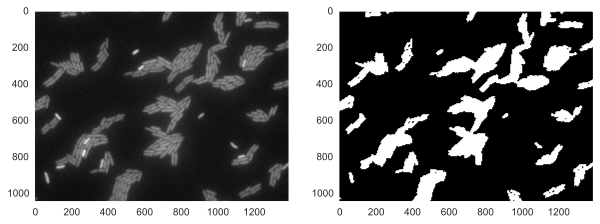

In [34]:
# Threshold value, as obtained by eye
thresh_cfp = 196

# Generate thresholded image
im_cfp_bw = im_cfp_filt > thresh_cfp

# Display phase and thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(im_cfp_filt, cmap=plt.cm.gray)
    ax[1].imshow(im_cfp_bw, cmap=plt.cm.gray)

Looks like we're doing much better!  Let's try overlapping the images now.

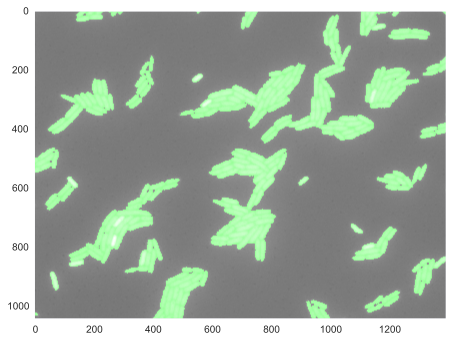

In [35]:
# Build RGB image by stacking grayscale images
im_cfp_rgb = np.dstack(3 * [im_cfp_filt / im_cfp_filt.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_cfp_rgb[im_cfp_bw, 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_cfp_rgb)

### Otsu's method for thresholding
It turns out that there is an automated way to find the threshold value, as opposed to eyeballing it like we have been doing.  Otsu's method provides this functionality.

In [36]:
# Compute Otsu thresholds for phase and cfp
thresh_phase_otsu = skimage.filters.threshold_otsu(im_phase)
thresh_cfp_otsu = skimage.filters.threshold_otsu(im_cfp_filt)

# Compare results to eyeballing it
print('Phase by eye: ', thresh_phase, '   CFP by eye: ', thresh_cfp)
print('Phase by Otsu:', thresh_phase_otsu,   
      '   CFP by Otsu:', thresh_cfp_otsu)

Phase by eye:  182    CFP by eye:  196
Phase by Otsu: 248    CFP by Otsu: 195


We see that for the CFP channel, the Otsu method did very well.  However, for phase, we see a big difference.  This is because the Otsu method assumes a bimodal distribution of pixels.  If we look at the histograms on a log scale, we see more clearly that the phase image has a long tail, which will trip up the Otsu algorithm.  The moral of the story is that you can use automated thresholding, but you should always do sanity checks to make sure it is working as expected.

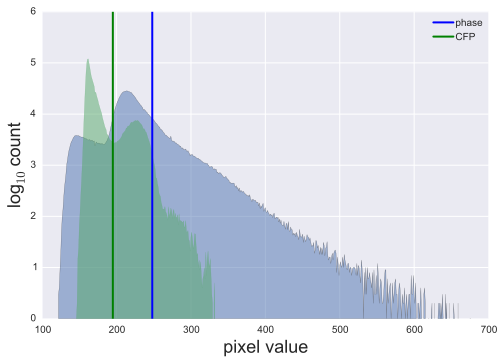

In [37]:
# Plot the histograms together.
plt.fill_between(bins_phase, np.log10(hist_phase), alpha=0.5)
plt.fill_between(bins_cfp, np.log10(hist_cfp), alpha=0.5,
                 color=sns.color_palette()[1])
plt.plot([thresh_phase_otsu, thresh_phase_otsu], [0, 6], 'b-')
plt.plot([thresh_cfp_otsu, thresh_cfp_otsu], [0, 6], 'g-')
plt.legend(('phase', 'CFP'), loc='upper right')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('log$_{10}$ count')

## Determining the bacterial area

Now that we have a thresholded image, we can determine the total area taken up by bacteria.  It's as simple as summing up the pixel values of the thresholded image!

In [38]:
# Compute bacterial area
bacterial_area_pix = im_cfp_bw.sum()

# Print out the result
print('bacterial area =', bacterial_area_pix, 'pixels')

bacterial area = 264447 pixels


If we want to get the total area that is bacterial in units of µm, we could use the interpixel distances to get the area represented by each pixel.  For this setup, the interpixel distance is 0.0636 µm.  We can then compute the bacterial area as follows.

In [39]:
# Define interpixel distance
interpix_dist = 0.0636 # microns

# Compute bacterial area
bacterial_area_micron = bacterial_area_pix * interpix_dist**2

# Print total area
print('bacterial area =', bacterial_area_micron, 'square microns')

bacterial area = 1069.67753712 square microns
